# Parse Logger Files
Parse raw logger data and utility to handle raw data.

In [1]:
#|hide
#|default_exp logger

In [26]:
#|export
from numpy.typing import NDArray,ArrayLike
import re
import gzip
import numpy as np
import pandas as pd
from scipy.stats import linregress
import logging

from pyrnet import utils

# logging setup
logging.basicConfig(
    filename='pyrnet.log',
    encoding='utf-8',
    level=logging.DEBUG,
    format='%(asctime)s %(name)s %(levelname)s:%(message)s'
)
logger = logging.getLogger(__name__)


# Local variables
_nat      = np.datetime64('NaT','ms')
_re_gprmc = re.compile('^(\d+,\d+ \d) \$GPRMC,(.*)(\*\w{2})$')
_re_adc   = re.compile('^(\d+)(\s\d+)+$')

In [3]:
import matplotlib.pyplot as plt

## Operations on the raw logger file
Open and read the binary files from the logger. These files have a header of 8 lines.

If the Logger receives power, it immediately starts to write data to the file. The first voltage measurements are good, but the GPS signal needs some time to establish.

If Logger writes data item per item, so if turned off, the file ends in an incomplete line most of the time. Sometimes, the last information is a GPS line. These events have to be handled.

### Reading the raw logger file:

In [4]:
#|dropout
fname = "../../example_data/Pyr9_000.bin"
if fname[-3:]=='.gz':
    f = gzip.open(fname,'rt',errors='ignore') # open in text mode, ignore non UTF8 characters
else:
    f = open(fname,'r',errors='ignore')
lines =[l.rstrip() for l in f.readlines()]
f.close()

print("=====Header and Start of Data=====:")
print(*lines[:15], sep='\n')
print('\n...\n')
print("==========End of Data=============:")
print(*lines[-10:], sep='\n')

=====Header and Start of Data=====:
# - TROPOS - Pyranometer Network BOX 9
#FIRMWARE: Logomatic Kwan v1.1 (modified Witthuhn 201803) Aug 23 2018 10:43:35
#    MAM setup: MAMCR=2, MAMTIM=4
#    SD Card Setup: result=3,   MID=3,   OID='SD',   PNM='SU02G',   PRV=128,   PSN=321248437
#    IDs: TROPOS_ID: A201300109 ; BOX: 9 ; WTS: 9
#        Pyr9 - serial:S12128.009 ; Pyr62 - serial:S12137.012
#    Calibration: Pyr9: 7.460000 (201504) ; Pyr62: 7.590000 (201504)
# time [ms] , [counts]...
891 836 322 484 194 1000 180
991 836 322 484 194 998 180
91 836 322 484 194 999 180
20800108,112102 0 $GPRMC,112102.067,V,,,,,0.00,0.00,080180,,,N*4C
191 836 322 485 194 1000 180
291 837 324 485 194 998 181
391 836 324 485 194 998 180

...

==========End of Data=============:
791 834 322 488 194 1000 180
891 835 323 488 194 998 180
991 834 322 486 194 998 180
91 835 322 486 194 997 180
191 838 322 486 194 1000 180
20030114,112109 0 $GPRMC,112109.000,A,5123.4125,N,01153.1148,E,0.21,0.00,140103,,,A*6D
291 836

### Cleanup
*  Skip almost empty files (data lines <20)
*  remove the last line as it is probably incomplete
*  check again if now a GPS line is the last line and remove it if so

In [5]:
# remove last line -> mostly damaged or empty
lines=lines[:-1]
# remove gps line at the end -> else processing issues
if _re_gprmc.match(lines[-1]):
    lines=lines[:-1]

### Divide GPS and ADC records
GPS and ADC lines have to be parsed separately

In [6]:
#|dropout
gpslines = []
adclines = []
for i,l in enumerate(lines):
    m = _re_gprmc.match(l)
    if m:
        gpslines.append(l)
        # -> send to parse_gps function
    elif _re_adc.match(l):
        adclines.append(l)
        # -> send to parse_adc function
    else:
        # unhandled record...
        pass

print("GPS lines:")
print(*gpslines, sep="\n")
print()
print("ADC lines:")
print(*adclines[:10], sep="\n")
print("...")

GPS lines:
20800108,112102 0 $GPRMC,112102.067,V,,,,,0.00,0.00,080180,,,N*4C
20800108,112103 0 $GPRMC,112103.067,V,,,,,0.00,0.00,080180,,,N*4D
20030114,112104 0 $GPRMC,112104.065,A,5123.4127,N,01153.1153,E,0.06,0.00,140103,,,A*6E
20030114,112105 0 $GPRMC,112105.065,A,5123.4127,N,01153.1154,E,0.05,0.00,140103,,,A*6B
20030114,112107 0 $GPRMC,112107.000,A,5123.4126,N,01153.1151,E,0.14,0.00,140103,,,A*6E
20030114,112108 0 $GPRMC,112108.000,A,5123.4126,N,01153.1150,E,0.20,0.00,140103,,,A*67
20030114,112109 0 $GPRMC,112109.000,A,5123.4125,N,01153.1148,E,0.21,0.00,140103,,,A*6D

ADC lines:
891 836 322 484 194 1000 180
991 836 322 484 194 998 180
91 836 322 484 194 999 180
191 836 322 485 194 1000 180
291 837 324 485 194 998 181
391 836 324 485 194 998 180
491 836 322 484 194 1000 181
591 836 322 484 194 999 180
691 837 322 484 194 998 180
791 829 322 484 194 1000 180
...


### Parsing GPS
Workflow:
1. Look if GPS is available (Status:*A*) if not return nan
2. Read lat,lon and time information
3. Account for GPS rollover

The GPS chip in use has no automatic patch to account for GPS week integer rollover, which happend at 2019-04-06. Measurements taken after this date, have to add 1024 weeks to the date the GPS provides. Therefore this parsing function requires the measurement date (to process older campaigns).

In [7]:
#|export
def parse_gprmc(s, date_of_measure=np.datetime64('now')):
    '''
    Parse a string with a GPRMC GPS record

    Parameters
    ----------
    s: string
        A GPRMC record
    date_of_measure: datetime or datetime64
        A rough time, when the measurements happen to account for GPS rollover.
        Precise datetime is only necessary for the period of 2019-05-06 to 2019-08-17.
        Otherwise, providing a year is sufficient.
        The default is np.datetime64("now"), which is sufficient for all measurements conducted later than 2019-08-17.

    Returns
    -------
    gprmc : tuple
        A tuple with datetime64,status,lat,lon
    '''
    date_of_measure = utils.to_datetime64(date_of_measure)
    # split fields of GPRMC record
    f = s.split(',')
    status = f[1]
    if status=='A':
        try:
            # parse latitude
            lat = float(f[2][:2])+float(f[2][2:])/60
            if f[3]=='S':
                lat *= -1.0
            # parse longitude
            lon = float(f[4][:3])+float(f[4][3:])/60
            if f[5]=='W':
                lon *= -1.0
            if date_of_measure>np.datetime64("2019-04-06") and date_of_measure<np.datetime64("2019-08-17"): #account for gps week rollover
                YY = '19'+f[8][4:6]
            else:
                YY = "20"+f[8][4:6]
            mm = f[8][2:4]
            dd = f[8][0:2]
            HH = f[0][0:2]
            MM = f[0][2:4]
            SS = f[0][4:]
            dt = np.datetime64(YY+'-'+mm+'-'+dd+'T'+HH+':'+MM+':'+SS,'ms')
            if date_of_measure>np.datetime64("2019-04-06"): #account for gps week rollover -> date jump 1024 weeks back at 2019-04-06
                dt= dt+np.timedelta64(1024,'W')
            r = (dt,status,lat,lon)
        except:
            return (_nat,'V',np.nan,np.nan)
    else:
        r = (_nat,'V',np.nan,np.nan)
    return r

### Parse ADC
The ADC output are simple tab separated voltage values of the 5 analog input pins of the Logger.
#### ADC (3.3V, 10bit) Analog In Pins:
* [0] Internal Battery measure
* [1] Temperature sensor (0-5V, measured with voltage split)
* [2] Humidity sensor (0-5V, measured with voltage split)
* [3] Pyranometer main (0  -$\mathrm{gain}*\mathrm{F}*\mathrm{C}$ V)
* [4] Battery (0-6V, measured with voltage split (same resistors))
* [5] None
* [6] Pyranometer secondary platform (0 - $\mathrm{gain}*\mathrm{F}*\mathrm{C}$ V)
* [7] None
* [8] None

with $\mathrm{gain}=300$, surface irradiance $\mathrm{F}$ of 0-1500 Wm-2, and calibration factor $\mathrm{C} < 8e-6 V\,Wm-2$, the voltage range of the pyranometer sensors spans the full available range (0-3.3V) depending on the calibration factor.

> *None* column won't appear in raw output file

> The first column is always milliseconds of processor runtime.

In [8]:
#|export
def parse_adc(s):
    '''
    Parse an ADC record

    Parameters
    ----------
    s: string
        The ADC record

    Returns
    -------
    t: tuple
       A tuple of digital counts of the ADC
    '''
    return tuple(map(int,s.split()))

### Putt all together
This function reads the logger file, separates GPS and ADC records, wich will be parsed by the functions introduced above. Then the data is collected

In [9]:
#|export
dtype_gprmc = [
    ( 'time',   'datetime64[ms]' ),
    ( 'status', 'S1' ),
    ( 'lat',    'f8' ),
    ( 'lon',    'f8' ),
    ( 'iadc',   'u4' )
]

def read_records(fname: str,
                 date_of_measure: np.datetime64 = np.datetime64('now')) -> (NDArray, NDArray):
    '''
    Read the GPRMC and ADC records from the pyranometer logger files

    Parameters
    ----------
    fname: string
        The filename of the logger file
    date_of_measure: numpy.datetime64
        Date of measurement to account for gps rollover

    Returns
    -------
    rec_adc: ndarray
        The 10bit ADC readings
    rec_gprmc: recarray
        The GPRMC GPS records
    '''
    logger.info(f"Start reading records from file: {fname}")
    date_of_measure = utils.to_datetime64(date_of_measure)
    # Read file, use errors='ignore' to skip non UTF-8 characters
    # non UTF-8 characters may arise in broken GPS strings from time to time
    if fname[-3:]=='.gz':
        f = gzip.open(fname,'rt',errors='ignore') # open in text mode, ignore non UTF8 characters
    else:
        f = open(fname,'r',errors='ignore')
    lines =[l.rstrip() for l in f.readlines()]
    f.close()

    ##- skip almost empty files
    if len(lines)<20:
        logger.info("Skip file, as number of records is < 20.")
        return False,False

    # remove last line -> mostly damaged or empty
    lines=lines[:-1]
    # remove gps line at the end -> else processing issues
    if _re_gprmc.match(lines[-1]):
        lines=lines[:-1]

    rec_gprmc = []
    rec_adc = []
    iadc = 0
    for i,l in enumerate(lines):
        m = _re_gprmc.match(l)
        if m:
            r = parse_gprmc(m.group(2), date_of_measure)
            if not np.isnat(r[0]):
                # add number of adc values before GPS line
                rec_gprmc.append(r+(iadc,))
        elif _re_adc.match(l):
            r = parse_adc(l)
            if iadc==0:
                adc_len=len(r)
            # if record line is incomplete (due to power cut off)
            # the line is dropped
            if len(r)==adc_len:
                rec_adc.append(r)
                iadc += 1
        else:
            # unhandled record...
            pass
    rec_adc   = np.array(rec_adc,dtype=np.uint16)
    rec_gprmc = np.array(rec_gprmc,dtype=dtype_gprmc).view(np.recarray)
    logger.info("Done reading records from raw file.")
    return rec_adc, rec_gprmc

In [10]:
rec_adc, rec_gprmc = read_records(fname)

In [11]:
#|dropout
rec_gprmc

rec.array([('2022-08-30T11:21:04.065', b'A', 51.39021167, 11.885255  , 26),
           ('2022-08-30T11:21:05.065', b'A', 51.39021167, 11.88525667, 35),
           ('2022-08-30T11:21:07.000', b'A', 51.39021   , 11.88525167, 54),
           ('2022-08-30T11:21:08.000', b'A', 51.39021   , 11.88525   , 64),
           ('2022-08-30T11:21:09.000', b'A', 51.39020833, 11.88524667, 74)],
          dtype=[('time', '<M8[ms]'), ('status', 'S1'), ('lat', '<f8'), ('lon', '<f8'), ('iadc', '<u4')])

In [12]:
#|dropout
rec_adc

array([[ 891,  836,  322,  484,  194, 1000,  180],
       [ 991,  836,  322,  484,  194,  998,  180],
       [  91,  836,  322,  484,  194,  999,  180],
       [ 191,  836,  322,  485,  194, 1000,  180],
       [ 291,  837,  324,  485,  194,  998,  181],
       [ 391,  836,  324,  485,  194,  998,  180],
       [ 491,  836,  322,  484,  194, 1000,  181],
       [ 591,  836,  322,  484,  194,  999,  180],
       [ 691,  837,  322,  484,  194,  998,  180],
       [ 791,  829,  322,  484,  194, 1000,  180],
       [ 891,  834,  322,  485,  194,  999,  180],
       [ 991,  836,  323,  486,  194, 1000,  181],
       [  91,  836,  324,  484,  194,  998,  180],
       [ 191,  836,  322,  483,  194,  998,  180],
       [ 291,  836,  322,  484,  194,  998,  180],
       [ 391,  835,  322,  484,  194, 1000,  180],
       [ 491,  836,  323,  484,  194,  998,  180],
       [ 591,  836,  322,  485,  194,  999,  180],
       [ 691,  836,  323,  486,  194,  999,  180],
       [ 791,  836,  322,  484,

## ADC time to milliseconds from start
The logger stores internally counted milliseconds from power up. The values are stored as the milliseconds from the last second only, we need a function to add up the seconds for a continuous time stamp.

In [13]:
#|export
def get_adc_time(rec_adc):
    """
    Get Milliseconds from Start of ADC measurement.

    Parameters
    ----------
    rec_adc: ndarray
        The digital counts of the ADC from the logger file.

    Returns
    -------
    ndarray
        Milliseconds from start of the measurement.
    """
    # get millisecond part
    ta = rec_adc[:,0].astype('timedelta64[ms]')
    # get time difference between records
    dt = np.diff(ta)
    dt[dt<np.timedelta64(-850,'ms')] += 1000
    # get cummulative time offset rel. to first ADC record
    ta[0] = 0
    ta[1:] = np.cumsum(dt)
    return ta

In [14]:
#|hideout
get_adc_time(rec_adc)

array([   0,  100,  200,  300,  400,  500,  600,  700,  800,  900, 1000,
       1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100,
       2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000, 3100, 3200,
       3300, 3400, 3500, 3600, 3700, 3800, 3900, 4000, 4100, 4200, 4300,
       4400, 4500, 4600, 4700, 4800, 4900, 5000, 5100, 5200, 5300, 5400,
       5500, 5600, 5700, 5800, 5900, 6000, 6100, 6200, 6300, 6400, 6500,
       6600, 6700, 6800, 6900, 7000, 7100, 7200, 7300, 7400, 7500, 7600],
      dtype='timedelta64[ms]')

## Sync GPS time to ADC records
The ADC is timed internally by the processor clock. This is prone to be not accurate. The following function attaches the GPS time to ADC samples in between two GPS lines by linear regression.

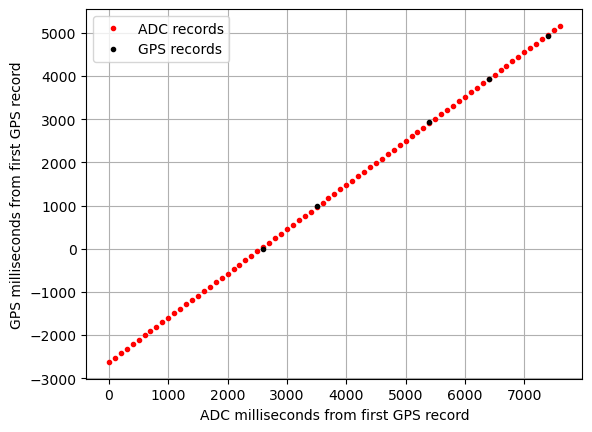

In [15]:
# get millisecond part
ta = get_adc_time(rec_adc)
### 2. Get logger clock for GPRMC records
# get time of previous ADC record
t1 = ta[rec_gprmc.iadc]/np.timedelta64(1,'ms')
# time of GPS records from GPRMC record
t2 = (rec_gprmc.time-rec_gprmc.time[0])/np.timedelta64(1,'ms')
a,b = linregress(t1,t2)[:2]
t = rec_gprmc.time[0]+ta*a+b.astype('timedelta64[ms]')

fig,ax = plt.subplots(1,1)
_ = ax.plot(ta/np.timedelta64(1,'ms'),
            a*ta/np.timedelta64(1,'ms')+b,
            'r.', label='ADC records')
_ = ax.plot(t1,t2,'k.', label='GPS records')
_ = ax.grid(True)
_ = ax.legend()
_ = ax.set_ylabel("GPS milliseconds from first GPS record")
_ = ax.set_xlabel("ADC milliseconds from first GPS record")
fig.show()


In [16]:
#|export
def sync_adc_time(adctime, gpstime, iadc):
    '''
    Synchronize the ADC time to the GPS records

    Parameters
    ----------
    adctime: ndarray
        Milliseconds from start of the ADC measurement.
    gpstime: ndarray
        GPS time
    iadc: ndarray of int
        Index of the last ADC sample before a GPS record has been stored.

    Returns
    -------
    time: ndarray(datetime64[ms])
        The time of the ADC records
    '''
    # assure milliseconds
    ta = adctime.astype('timedelta64[ms]')
    # assure int type
    iadc = np.array(iadc).astype(int)
    # get GPStime of the previous ADC record
    # here we assume, that the last ADC sample stored before a GPS record
    # has the same time as the GPS timestamp
    t1 = ta[iadc]/np.timedelta64(1,'ms')
    # time of GPS records from GPRMC record
    t2 = (gpstime-gpstime[0])/np.timedelta64(1,'ms')
    a,b = linregress(t1,t2)[:2]
    t = gpstime[0]+ta*a+b.astype('timedelta64[ms]')

    logger.info('Sync ADC time to GPS Fit Summary:')
    logger.info('|-- Drift  : {0:7.2f} [s/day]'.format( (1/a-1)*86400 ))
    logger.info('|-- Slope  : {0:13.8f}'.format(a))
    logger.info('|-- Offset : {0:7.2f} [s]'.format(b/1000))
    logger.info('|-- Jitter : {0:7.2f} [ms]'.format(np.std(t2-(a*t1+b))))
    return t

In [17]:
#|dropout
adctime = get_adc_time(rec_adc)
time = sync_adc_time(
    adctime=adctime,
    gpstime=rec_gprmc.time,
    iadc=rec_gprmc.iadc,
)
time

array(['2022-08-30T11:21:01.443', '2022-08-30T11:21:01.545',
       '2022-08-30T11:21:01.647', '2022-08-30T11:21:01.750',
       '2022-08-30T11:21:01.852', '2022-08-30T11:21:01.955',
       '2022-08-30T11:21:02.057', '2022-08-30T11:21:02.160',
       '2022-08-30T11:21:02.262', '2022-08-30T11:21:02.364',
       '2022-08-30T11:21:02.467', '2022-08-30T11:21:02.569',
       '2022-08-30T11:21:02.672', '2022-08-30T11:21:02.774',
       '2022-08-30T11:21:02.877', '2022-08-30T11:21:02.979',
       '2022-08-30T11:21:03.081', '2022-08-30T11:21:03.184',
       '2022-08-30T11:21:03.286', '2022-08-30T11:21:03.389',
       '2022-08-30T11:21:03.491', '2022-08-30T11:21:03.594',
       '2022-08-30T11:21:03.696', '2022-08-30T11:21:03.799',
       '2022-08-30T11:21:03.901', '2022-08-30T11:21:04.003',
       '2022-08-30T11:21:04.106', '2022-08-30T11:21:04.208',
       '2022-08-30T11:21:04.311', '2022-08-30T11:21:04.413',
       '2022-08-30T11:21:04.516', '2022-08-30T11:21:04.618',
       '2022-08-30T11:21

## Binning of ADC values
The original time resolution is about 10Hz. Here we apply binning of ADC samples to a regular spaced time grid.

We declare *bins* as the desired number of bins per day, e.g. ```bins = 86400``` one bin every second.

In [18]:
# Desired bins per day
bins = 86400

Now we can calculate the bin number each sample is assigned to.

In [19]:
# starting day
t0 = time[0].astype('datetime64[D]')
# convert time to 'days from t0'
dday = (time-t0)/np.timedelta64(1,'D')
# calculate the bin number assigned to every sample
it = np.int64(dday*bins)
it

array([40861, 40861, 40861, 40861, 40861, 40861, 40862, 40862, 40862,
       40862, 40862, 40862, 40862, 40862, 40862, 40862, 40863, 40863,
       40863, 40863, 40863, 40863, 40863, 40863, 40863, 40864, 40864,
       40864, 40864, 40864, 40864, 40864, 40864, 40864, 40864, 40865,
       40865, 40865, 40865, 40865, 40865, 40865, 40865, 40865, 40865,
       40866, 40866, 40866, 40866, 40866, 40866, 40866, 40866, 40866,
       40866, 40867, 40867, 40867, 40867, 40867, 40867, 40867, 40867,
       40867, 40867, 40868, 40868, 40868, 40868, 40868, 40868, 40868,
       40868, 40868, 40869, 40869, 40869])

Calculate number of samples per bins (*cnt*) and a bin index starting with the first bin (*inv_idx*)

In [20]:
uval,inv_idx,cnt = np.unique(it,return_inverse=True,return_counts=True)
uval,inv_idx,cnt

(array([40861, 40862, 40863, 40864, 40865, 40866, 40867, 40868, 40869]),
 array([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7,
        7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8]),
 array([ 6, 10,  9, 10, 10, 10, 10,  9,  3]))

Now [np.bincount](https://numpy.org/doc/stable/reference/generated/numpy.bincount.html) can be used to calculate the average value of the samples in every bin.

In [21]:
binvalues = np.bincount(inv_idx,weights=rec_adc[:,2])/cnt
print('rec_adc values of the fist bin, 3rd column')
print(rec_adc[inv_idx==0,2])
print("Average calculated with bincount:")
print(binvalues[0])

rec_adc values of the fist bin, 3rd column
[322 322 322 322 324 324]
Average calculated with bincount:
322.6666666666667


Time values for each bin are assigned as the starting boundary of the sample times within the bin.

In [22]:
# assign bin time
bintime = t0+ np.timedelta64(86400000,'ms')*uval.astype(np.float64)/bins
print('sample time for the fist bin:')
print(time[inv_idx==0])
print("Assigned bin time:")
print(bintime[0])

sample time for the fist bin:
['2022-08-30T11:21:01.443' '2022-08-30T11:21:01.545'
 '2022-08-30T11:21:01.647' '2022-08-30T11:21:01.750'
 '2022-08-30T11:21:01.852' '2022-08-30T11:21:01.955']
Assigned bin time:
2022-08-30T11:21:01.000


In [23]:
#|export
def adc_binning(rec_adc, time, bins=86400):
    """
    Binning and averaging of ADC samples

    Parameters
    ----------
    rec_adc: ndarray
        The ADC records parsed from the logger.
    time: ndarray of time objects
        Sample time of ADC records.
    bins: int
        Number of desired bins per day. The default is 86400, which result in
        mean values of 1 second steps per day. Maximum resolution is 86400000.

    Returns
    -------
    ndarray, ndarray(datetime64)
        Binned ADC records and corresponding time.
    """
    time = utils.to_datetime64(time)
    # starting day
    t0 = time[0].astype('datetime64[D]')
    # convert time to 'days from t0'
    dday = (time-t0)/np.timedelta64(1,'D')
    # calculate time bins of output dataset
    it = np.int64(dday*bins)
    # index for unique bins (inv_idx) and count of samples per bin (cnt)
    uval, inv_idx, cnt = np.unique(it,
                                   return_inverse=True,
                                   return_counts=True)
    logger.info(f"ADC records fill {len(uval)} bins of data.")
    # Calculate average of sample values per bin
    # The first two columns of rec_adc will be omitted as they store the
    # internal measures for timing and battery (first two columns)
    V = np.zeros((len(uval),rec_adc.shape[1]-2))
    for i in range(V.shape[1]):
        V[:,i] = np.bincount(inv_idx,weights=rec_adc[:,i+2])/cnt
    bintime = t0+ np.timedelta64(86400000,'ms')*uval.astype(np.float64)/bins
    logger.info(f"ADC records span a time period from {bintime[0]} to {bintime[-1]}.")
    return V, bintime

 In a similar way we can do it for a dataset:

In [ ]:
#|export
def resample_mean(ds,freq='1s'):

    # start and end bin time
    start_time = np.datetime64(
       pd.to_datetime(ds.time.values[0]).floor(freq)
    )
    end_time = np.datetime64(
        pd.to_datetime(ds.time.values[-1]).floor(freq)
    )

    # bin time
    bintime = pd.date_range(
        start_time,
        end_time,
        freq=freq
    ).floor(freq)

    ds_r = ds.assign_coords(
        {
            "time_resampled": ("time_resampled", bintime)
        }
    )

    # calculate bin index of output dataset
    it = np.int64(
        (ds.time.values - start_time)/pd.Timedelta(freq)
    )

    # index for unique bins (inv_idx) and count of samples per bin (cnt)
    uval, inv_idx, cnt = np.unique(it,
                                   return_inverse=True,
                                   return_counts=True)

    # apply to all time dependend variables
    for var in ds:
        if 'time' in ds[var].dims:
            # replace time dimension with time_resampled
            vardims = ds[var].dims
            newdims = [d if d!='time' else 'time_resampled' for d in vardims]
            # if only time dimension, take the shortcut
            if len(vardims)==1:
                newval = np.bincount(inv_idx,weights=ds[var].values)/cnt
                ds_r = ds_r.assign( {var: (newdims, newval)})
            elif len(vardims)==2: # more than the time dimension, assume 2
                N = ds[var].shape[1]
                newval = np.zeros((bintime.size,N))
                for i in range(N):
                    newval[:,i] = np.bincount(inv_idx,weights=ds[var].values[:,i])/cnt
                ds_r = ds_r.assign( {var: (newdims, newval)})
            else:
                raise ValueError("logger.resample is implemented for 2dims only.")
        # add attributes again
        ds_r[var].attrs.update(ds[var].attrs)
        ds_r[var].encoding.update(ds[var].encoding)

    # drop original time and rename
    ds_r = ds_r.drop_dims("time").rename({"time_resampled":"time"})
    # add time encoding
    ds_r.time.encoding.update({
        "units": f"seconds since {np.datetime_as_string(ds_r.time.data[0], unit='D')}T00:00Z",
    })

    return ds_r


## Interpolate GPS coordinates

In [24]:
#|export
def interpolate_coords(rec_gprmc, time):
    """
    Interpolate lat and lon from gps records

    Parameters
    ----------
    rec_gprmc: recarray
        The GPRMC records from the logger file
    time: list or array of time objects

    Returns
    -------
    ndarray, ndarray
        lat and lon interpolated from GPS records to `time`
    """
    time = utils.to_datetime64(time)
    t0 = time[0].astype('datetime64[D]')
    # coordinate variables
    x1 = (time-t0)/np.timedelta64(1,'ms')
    x2 = (rec_gprmc.time-t0)/np.timedelta64(1,'ms')
    lat = np.interp(x1,x2,rec_gprmc.lat)
    lon = np.interp(x1,x2,rec_gprmc.lon)
    return lat, lon

In [25]:
#|hide
# Export module
# Requires *nbdev* to export and update the *../lib/logger.py* module
import nbdev.export
import nbformat as nbf
name = "logger"

# Export python module
nbdev.export.nb_export( f"{name}.ipynb" ,f"../../src/pyrnet")

# Export to docs
ntbk = nbf.read(f"{name}.ipynb", nbf.NO_CONVERT)

text_search_dict = {
    "#|hide": "remove-cell",  # Remove the whole cell
    "#|dropcode": "hide-input",  # Hide the input w/ a button to show
    "#|dropout": "hide-output"  # Hide the output w/ a button to show
}
for cell in ntbk.cells:
    cell_tags = cell.get('metadata', {}).get('tags', [])
    for key, val in text_search_dict.items():
            if key in cell['source']:
                if val not in cell_tags:
                    cell_tags.append(val)
    if len(cell_tags) > 0:
        cell['metadata']['tags'] = cell_tags
    nbf.write(ntbk, f"../../docs/source/nbs/{name}.ipynb")